In [1]:
!pip install semtorch
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
%matplotlib inline
import numpy as np

In [3]:
number_of_the_seed = 100

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
#My file path is being desing to look like this one. 
path = Path("../dataset2/")
#image is a normal microscope image. It's in png format. 
path_images = path/"Images"
#labels are the masks balck and white. In tif format. 
path_labels = path/"Labels"

test_name = "test"

In [5]:
get_y_fn = lambda x: path_labels/manual_name/f'Mask_{str(x.stem[-3:])}.tif'

In [6]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['NoSpheroid']


{'NoSpheroid': 0, 'Spheroid': 1}


In [8]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=5

In [9]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [10]:
def pixel_accuracy(inp, targ, axis):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    
    #the mask is the targ pixels different from NoSpheroid
    mask = targ != void_code
    #[0]
    #when the predicted pixels and targets pixels named spheroid correlates, we calculate the mean. 
    return (pred[mask] == targ[mask]).float().mean()

In [11]:
def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)]

In [12]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [13]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

# Manual

In [14]:
manual_name="manual"

path_manual_img = path_images/manual_name
path_manual_lbl = path_labels/manual_name

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

../dataset2/Images/manual/Droplet_101.jpg


<AxesSubplot:>

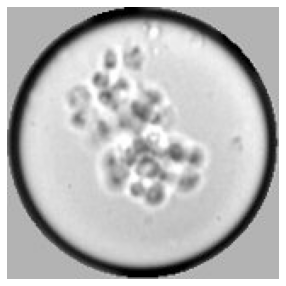

In [16]:
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [17]:
print(get_y_fn(img_f))

../dataset2/Labels/manual/Mask_101.tif


<AxesSubplot:>

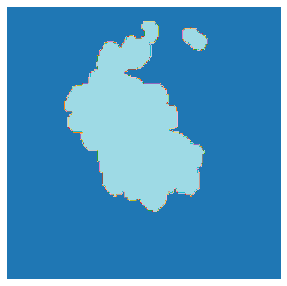

In [18]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [19]:
#print(torch.max(image2tensor(mask))

In [20]:
size = 160
bs = 32

Setting-up type transforms pipelines
Found 630 items
2 datasets of sizes 567,63
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../dataset2/Images/manual/Droplet_264.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=160x160
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../dataset2/Images/manual/Droplet_264.jpg
    applying <lambda> gives
      ../dataset2/Labels/manual/Mask_264.tif
    applying PILBase.create gives
      PILMask mode=L size=171x171

Final sample: (PILImage mode=RGB size=160x160, PILMask mode=L size=171x171)


Found 630 items
2 datasets of sizes 567,63
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (160, 160), 'method': 'crop', 'pad_mode': 'reflection', 'resam

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


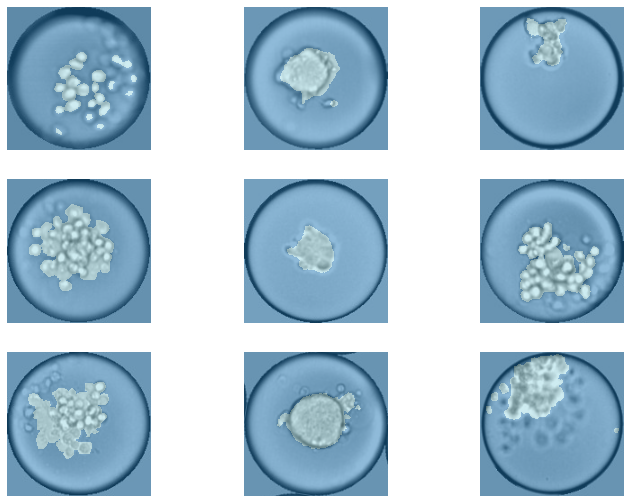

In [21]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# First round of training 

Here weight decay set to 1e-2

In [23]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[partial(pixel_accuracy, axis=1), Dice(), JaccardCoeff()],wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

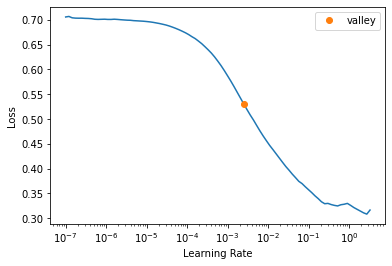

In [24]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.182561,0.551370,0.003507,0.006968,0.003496,00:05
1,0.134903,0.112835,0.771835,0.829028,0.707983,00:05
2,0.116058,0.081158,0.899617,0.874389,0.776812,00:05
3,0.105179,0.096674,0.763657,0.828333,0.706969,00:05
4,0.098685,0.077660,0.931578,0.879352,0.784682,00:05
5,0.093941,0.075485,0.885936,0.880366,0.786298,00:05
6,0.090851,0.092366,0.919576,0.876474,0.780110,00:05
7,0.088518,0.092645,0.915367,0.874581,0.777115,00:05
8,0.085759,0.074251,0.908638,0.886581,0.796269,00:05
9,0.083150,0.088719,0.933655,0.878283,0.782980,00:05


Better model found at epoch 0 with valid_loss value: 0.5513696074485779.


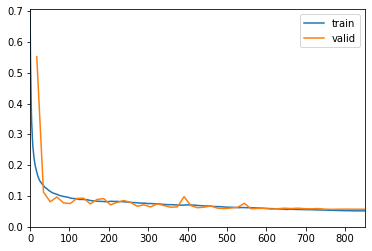

Better model found at epoch 1 with valid_loss value: 0.11283501982688904.
Better model found at epoch 2 with valid_loss value: 0.08115777373313904.
Better model found at epoch 4 with valid_loss value: 0.07765975594520569.
Better model found at epoch 5 with valid_loss value: 0.07548487931489944.
Better model found at epoch 8 with valid_loss value: 0.07425101846456528.
Better model found at epoch 11 with valid_loss value: 0.07123900949954987.
Better model found at epoch 15 with valid_loss value: 0.06666988879442215.
Better model found at epoch 17 with valid_loss value: 0.06448782235383987.
Better model found at epoch 20 with valid_loss value: 0.06345593184232712.
Better model found at epoch 24 with valid_loss value: 0.06185412034392357.
Better model found at epoch 27 with valid_loss value: 0.06044314429163933.
Better model found at epoch 28 with valid_loss value: 0.05900862067937851.
Better model found at epoch 32 with valid_loss value: 0.05840369686484337.
Better model found at epoch 35

In [36]:
fname="Deeplabv3_Aug_wd2_model_1_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-3,1e-1),cbs=callbacksFitBeforeUnfreeze)

Now it is rule of thumb

In [37]:
learn.load("Deeplabv3_Aug_wd2_model_1_resnet50_bs_32")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.05659785494208336,0.9176910519599915,0.9102176432462648,0.8352288304222861]

In [38]:
lr = 1e-2
lrs = slice(lr/400, lr/4)
lr, lrs

(0.01, slice(2.5e-05, 0.0025, None))

In [39]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.051282,0.056550,0.917417,0.910377,0.835497,00:05
1,0.051121,0.056313,0.915839,0.910518,0.835736,00:05
2,0.051346,0.056892,0.915416,0.910295,0.835359,00:05
3,0.051291,0.056824,0.918367,0.910960,0.836480,00:05
4,0.050848,0.056297,0.921197,0.911714,0.837752,00:05
5,0.050592,0.056822,0.920862,0.911033,0.836602,00:05
6,0.050891,0.056820,0.912896,0.909993,0.834850,00:05
7,0.050833,0.056735,0.920198,0.911171,0.836835,00:05
8,0.050804,0.058285,0.911736,0.908691,0.832662,00:05
9,0.051272,0.056472,0.907878,0.910329,0.835417,00:05


Better model found at epoch 0 with valid_loss value: 0.056549638509750366.


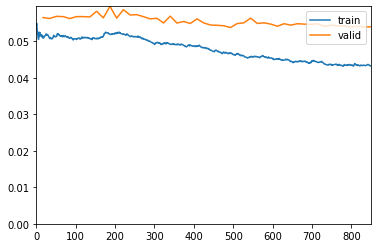

Better model found at epoch 1 with valid_loss value: 0.05631311237812042.
Better model found at epoch 4 with valid_loss value: 0.056296780705451965.
Better model found at epoch 16 with valid_loss value: 0.05620712786912918.
Better model found at epoch 18 with valid_loss value: 0.055082596838474274.
Better model found at epoch 20 with valid_loss value: 0.055066078901290894.
Better model found at epoch 22 with valid_loss value: 0.05494075268507004.
Better model found at epoch 25 with valid_loss value: 0.05451897904276848.
Better model found at epoch 26 with valid_loss value: 0.05444585904479027.
Better model found at epoch 27 with valid_loss value: 0.05431201308965683.
Better model found at epoch 28 with valid_loss value: 0.05381252244114876.


In [40]:
fname="Deeplabv3_Aug_wd2_model_2_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lrs,cbs=callbacksFitBeforeUnfreeze)

Now, let's calculate again the lr rate of the last model and retrain it. 

In [25]:
learn.load("Deeplabv3_Aug_wd2_model_2_resnet50_bs_32")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.05381252244114876,0.9160792231559753,0.9146020875368617,0.8426422024908058]

Recorder

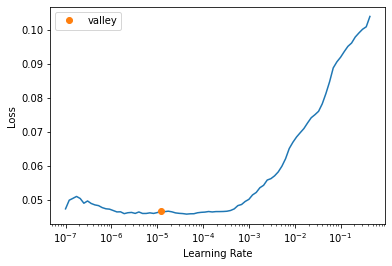

In [42]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [43]:
lrs = slice(1e-7,1e-6)

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.044910,0.053953,0.917563,0.914683,0.842779,00:05
1,0.045316,0.054048,0.919338,0.914665,0.842749,00:05
2,0.045811,0.054378,0.920127,0.914425,0.842341,00:05
3,0.045940,0.053931,0.918557,0.914869,0.843095,00:05
4,0.046048,0.054297,0.919850,0.914409,0.842314,00:05
5,0.045878,0.053957,0.918014,0.914729,0.842858,00:05
6,0.045886,0.053909,0.917473,0.914594,0.842628,00:05
7,0.045967,0.054011,0.920804,0.915044,0.843393,00:05
8,0.045898,0.054097,0.915734,0.914276,0.842089,00:05
9,0.045716,0.054127,0.922860,0.914951,0.843236,00:05


Better model found at epoch 0 with valid_loss value: 0.05395260825753212.


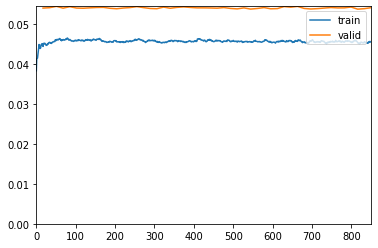

Better model found at epoch 3 with valid_loss value: 0.05393067002296448.
Better model found at epoch 6 with valid_loss value: 0.05390869826078415.
Better model found at epoch 10 with valid_loss value: 0.05389570817351341.
Better model found at epoch 11 with valid_loss value: 0.053781162947416306.
Better model found at epoch 29 with valid_loss value: 0.05374997854232788.
Better model found at epoch 31 with valid_loss value: 0.05369929224252701.
Better model found at epoch 47 with valid_loss value: 0.05367831513285637.


In [44]:
fname="Deeplabv3_Aug_wd2_model_3_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lrs,cbs=callbacksFitBeforeUnfreeze)

In [25]:
learn.load("Deeplabv3_Aug_wd2_model_3_resnet50_bs_32")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.05367831513285637,0.9200477004051208,0.9152454730412174,0.8437351034682468]

Recorder

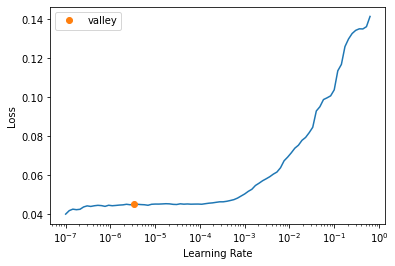

In [26]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.045259,0.053853,0.919754,0.914937,0.843211,00:06
1,0.045440,0.053791,0.921371,0.915298,0.843825,00:06
2,0.045359,0.053732,0.921528,0.915478,0.844131,00:06
3,0.045311,0.053908,0.917779,0.914786,0.842954,00:06
4,0.045449,0.054057,0.919380,0.914798,0.842975,00:06
5,0.045718,0.054136,0.922314,0.915207,0.843669,00:06
6,0.045882,0.054117,0.920489,0.914901,0.843150,00:06
7,0.045622,0.054010,0.921368,0.915004,0.843325,00:06
8,0.045480,0.054053,0.921126,0.914789,0.842960,00:06
9,0.045316,0.053865,0.919175,0.915010,0.843335,00:06


Better model found at epoch 0 with valid_loss value: 0.05385349690914154.


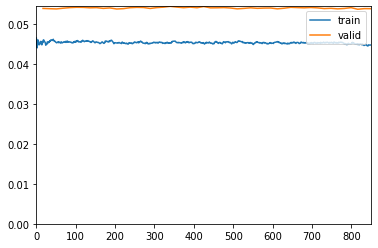

Better model found at epoch 1 with valid_loss value: 0.05379069969058037.
Better model found at epoch 2 with valid_loss value: 0.05373165011405945.
Better model found at epoch 11 with valid_loss value: 0.053714342415332794.
Better model found at epoch 47 with valid_loss value: 0.05364830046892166.


In [27]:
fname="Deeplabv3_Aug_wd2_model_4_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-7,5e-6),cbs=callbacksFitBeforeUnfreeze)

# Second round of training 

Noe, let's set the weigth decay to 1e-1 

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[partial(pixel_accuracy, axis=1), Dice(), JaccardCoeff()],wd=1e-1,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

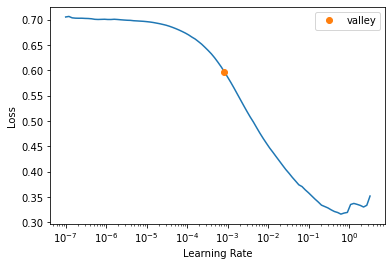

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.182644,0.558939,0.002148,0.004264,0.002137,00:05
1,0.135006,0.112155,0.766817,0.826817,0.704764,00:05
2,0.116124,0.079534,0.895730,0.876059,0.779452,00:05
3,0.105268,0.088167,0.827598,0.855202,0.747033,00:05
4,0.098735,0.072725,0.899108,0.880955,0.787238,00:05
5,0.094687,0.075962,0.891512,0.879330,0.784647,00:05
6,0.091797,0.113153,0.927892,0.855282,0.747155,00:05
7,0.090003,0.108041,0.893943,0.852233,0.742514,00:05
8,0.088307,0.076638,0.897888,0.881356,0.787879,00:05
9,0.085711,0.072626,0.917863,0.888337,0.799107,00:05


Better model found at epoch 0 with valid_loss value: 0.5589392781257629.


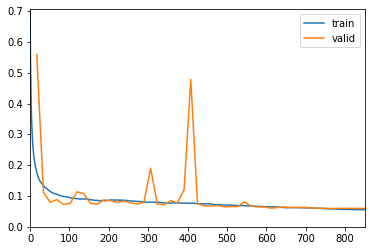

Better model found at epoch 1 with valid_loss value: 0.11215497553348541.
Better model found at epoch 2 with valid_loss value: 0.07953404635190964.
Better model found at epoch 4 with valid_loss value: 0.07272503525018692.
Better model found at epoch 9 with valid_loss value: 0.07262581586837769.
Better model found at epoch 19 with valid_loss value: 0.07126731425523758.
Better model found at epoch 25 with valid_loss value: 0.06786110252141953.
Better model found at epoch 26 with valid_loss value: 0.06722646951675415.
Better model found at epoch 28 with valid_loss value: 0.0648815855383873.
Better model found at epoch 33 with valid_loss value: 0.06453271210193634.
Better model found at epoch 34 with valid_loss value: 0.06430932879447937.
Better model found at epoch 35 with valid_loss value: 0.06061626598238945.
Better model found at epoch 42 with valid_loss value: 0.06043447554111481.
Better model found at epoch 43 with valid_loss value: 0.05962498113512993.
Better model found at epoch 44

In [24]:
fname="Deeplabv3_Aug_wd1_model_1_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-3,1e-1),cbs=callbacksFitBeforeUnfreeze)

Now it is rule of thumb

In [26]:
learn.load("Deeplabv3_Aug_wd1_model_1_resnet50_bs_32")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.08047445863485336,0.8769883513450623,0.8676152954362875,0.7661842233824273]

In [25]:
lr = 1e-2
lrs = slice(lr/400, lr/4)
lr, lrs

(0.01, slice(2.5e-05, 0.0025, None))

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.055292,0.059864,0.914051,0.904967,0.826429,00:05
1,0.054931,0.059605,0.912336,0.905472,0.827271,00:05
2,0.055294,0.060036,0.910641,0.904830,0.826200,00:05
3,0.054908,0.059308,0.913741,0.905868,0.827933,00:05
4,0.054677,0.058734,0.912692,0.907179,0.830125,00:05
5,0.054479,0.060108,0.915246,0.905703,0.827658,00:05
6,0.054714,0.057249,0.917978,0.908231,0.831889,00:06
7,0.054782,0.057274,0.919568,0.908332,0.832059,00:05
8,0.054696,0.058657,0.908381,0.906886,0.829635,00:05
9,0.055279,0.058254,0.905706,0.906697,0.829320,00:06


Better model found at epoch 0 with valid_loss value: 0.059863898903131485.


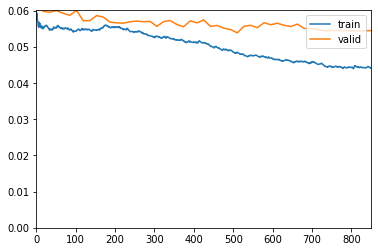

Better model found at epoch 1 with valid_loss value: 0.059605229645967484.
Better model found at epoch 3 with valid_loss value: 0.05930806323885918.
Better model found at epoch 4 with valid_loss value: 0.058733921498060226.
Better model found at epoch 6 with valid_loss value: 0.05724944919347763.
Better model found at epoch 10 with valid_loss value: 0.05686240643262863.
Better model found at epoch 11 with valid_loss value: 0.056659433990716934.
Better model found at epoch 12 with valid_loss value: 0.05656109005212784.
Better model found at epoch 17 with valid_loss value: 0.05568266659975052.
Better model found at epoch 21 with valid_loss value: 0.05557962879538536.
Better model found at epoch 27 with valid_loss value: 0.055191271007061005.
Better model found at epoch 28 with valid_loss value: 0.054801031947135925.
Better model found at epoch 29 with valid_loss value: 0.053900908678770065.


In [27]:
fname="Deeplabv3_Aug_wd1_model_2_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lrs,cbs=callbacksFitBeforeUnfreeze)

Now, let's calculate again the lr rate of the last model and retrain it. 

In [28]:
learn.load("Deeplabv3_Aug_wd1_model_2_resnet50_bs_32")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.053900908678770065,0.916683554649353,0.9156269332007132,0.844383691586276]

Recorder

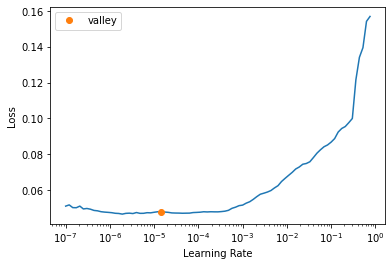

In [29]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [30]:
lrs = slice(1e-7,1e-6)

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.046083,0.054095,0.917434,0.915443,0.844071,00:06
1,0.046560,0.054064,0.919751,0.915725,0.844551,00:05
2,0.047077,0.054538,0.920410,0.915321,0.843864,00:05
3,0.046933,0.054219,0.918794,0.915535,0.844227,00:05
4,0.046799,0.054292,0.918580,0.915342,0.843899,00:05
5,0.047120,0.054075,0.917367,0.915510,0.844184,00:05
6,0.047356,0.054163,0.917131,0.915263,0.843765,00:05
7,0.047414,0.054129,0.920313,0.915915,0.844874,00:05
8,0.047355,0.053922,0.917445,0.915567,0.844282,00:06
9,0.047220,0.054414,0.922652,0.915536,0.844228,00:06


Better model found at epoch 0 with valid_loss value: 0.05409468710422516.


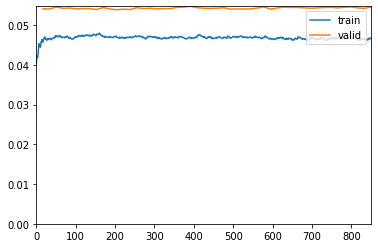

Better model found at epoch 1 with valid_loss value: 0.054063934832811356.
Better model found at epoch 8 with valid_loss value: 0.05392210930585861.
Better model found at epoch 11 with valid_loss value: 0.053867023438215256.


In [31]:
fname="Deeplabv3_Aug_wd1_model_3_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lrs,cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.load("Deeplabv3_Aug_wd1_model_3_resnet50_bs_32")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.053867023438215256,0.9173319339752197,0.9158254873101739,0.8447214692752923]

Recorder

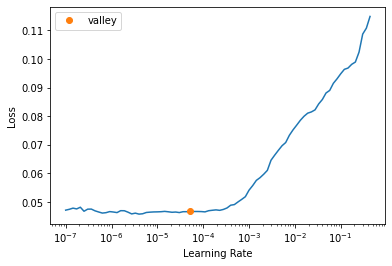

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.046195,0.053826,0.918969,0.915957,0.844946,00:06
1,0.046589,0.054088,0.920155,0.915751,0.844594,00:06
2,0.046809,0.054367,0.920227,0.915497,0.844162,00:06
3,0.046822,0.054267,0.919588,0.915563,0.844275,00:06
4,0.046874,0.054260,0.920879,0.915762,0.844613,00:06
5,0.047006,0.054339,0.918947,0.915323,0.843867,00:06
6,0.047100,0.054312,0.918757,0.915346,0.843906,00:06
7,0.046884,0.054284,0.920544,0.915699,0.844506,00:06
8,0.046592,0.054146,0.920270,0.915542,0.844240,00:06
9,0.046757,0.054058,0.918218,0.915429,0.844047,00:06


Better model found at epoch 0 with valid_loss value: 0.05382564291357994.


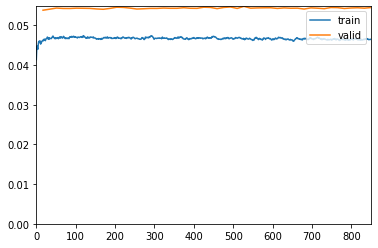

In [25]:
fname="Deeplabv3_Aug_wd1_model_4_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-7,5e-6),cbs=callbacksFitBeforeUnfreeze)

# Third round of training 

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[partial(pixel_accuracy, axis=1), Dice(), JaccardCoeff()],wd=1e-3,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Recorder

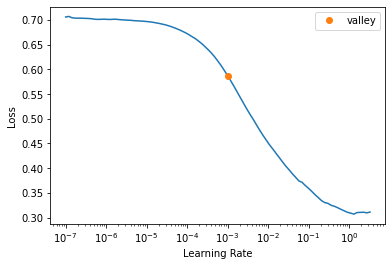

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.182681,0.553229,0.003314,0.006611,0.003316,00:05
1,0.135063,0.111702,0.770947,0.828504,0.707218,00:05
2,0.116092,0.081645,0.901063,0.875549,0.778645,00:05
3,0.105310,0.087423,0.841962,0.861344,0.756457,00:05
4,0.098971,0.074388,0.923535,0.882883,0.790323,00:05
5,0.094430,0.073645,0.888995,0.882768,0.790139,00:05
6,0.091125,0.088475,0.922265,0.876076,0.779480,00:05
7,0.088725,0.078975,0.886010,0.878284,0.782983,00:05
8,0.086176,0.073765,0.902004,0.889199,0.800503,00:05
9,0.083423,0.081885,0.928031,0.883427,0.791195,00:05


Better model found at epoch 0 with valid_loss value: 0.5532285571098328.


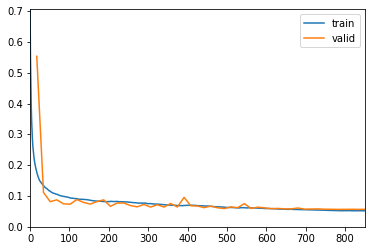

Better model found at epoch 1 with valid_loss value: 0.11170247942209244.
Better model found at epoch 2 with valid_loss value: 0.08164505660533905.
Better model found at epoch 4 with valid_loss value: 0.0743883028626442.
Better model found at epoch 5 with valid_loss value: 0.0736454576253891.
Better model found at epoch 11 with valid_loss value: 0.0663958489894867.
Better model found at epoch 15 with valid_loss value: 0.06469722092151642.
Better model found at epoch 17 with valid_loss value: 0.06398603320121765.
Better model found at epoch 25 with valid_loss value: 0.062177035957574844.
Better model found at epoch 27 with valid_loss value: 0.06170709431171417.
Better model found at epoch 28 with valid_loss value: 0.05930481106042862.
Better model found at epoch 35 with valid_loss value: 0.05876118689775467.
Better model found at epoch 37 with valid_loss value: 0.05805116891860962.
Better model found at epoch 40 with valid_loss value: 0.057272907346487045.
Better model found at epoch 43

In [24]:
fname="Deeplabv3_Aug_wd3_model_1_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-3,1e-1) ,cbs=callbacksFitBeforeUnfreeze)

In [27]:
learn.freeze()
learn.load("Deeplabv3_Aug_wd3_model_1_resnet50_bs_32")
learn.validate()

(#4) [0.056495483964681625,0.9144963026046753,0.9097416736953785,0.8344276321914499]

In [28]:
learn.unfreeze()

In [29]:
lr = 1e-2
lrs = slice(lr/400, lr/4)
lr, lrs

(0.01, slice(2.5e-05, 0.0025, None))

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.051915,0.056530,0.915415,0.909826,0.834570,00:05
1,0.051689,0.056324,0.914814,0.909714,0.834381,00:05
2,0.051840,0.056670,0.918070,0.909871,0.834644,00:05
3,0.051608,0.056239,0.917497,0.910347,0.835446,00:05
4,0.051259,0.056035,0.921208,0.910962,0.836483,00:05
5,0.051027,0.056127,0.917677,0.910442,0.835607,00:05
6,0.051018,0.055581,0.917430,0.911553,0.837481,00:06
7,0.050993,0.056320,0.914725,0.909949,0.834776,00:05
8,0.050937,0.055985,0.918441,0.911630,0.837611,00:05
9,0.051566,0.055538,0.907642,0.910877,0.836340,00:05


Better model found at epoch 0 with valid_loss value: 0.05653046816587448.


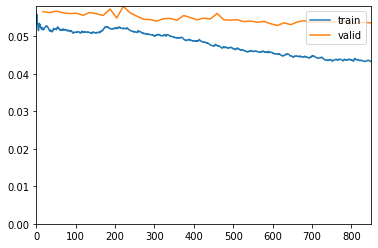

Better model found at epoch 1 with valid_loss value: 0.05632375180721283.
Better model found at epoch 3 with valid_loss value: 0.05623883008956909.
Better model found at epoch 4 with valid_loss value: 0.05603507161140442.
Better model found at epoch 6 with valid_loss value: 0.05558052659034729.
Better model found at epoch 9 with valid_loss value: 0.05553770065307617.
Better model found at epoch 11 with valid_loss value: 0.05484534800052643.
Better model found at epoch 15 with valid_loss value: 0.0545196458697319.
Better model found at epoch 16 with valid_loss value: 0.05443975701928139.
Better model found at epoch 17 with valid_loss value: 0.0540158711373806.
Better model found at epoch 30 with valid_loss value: 0.05389704182744026.
Better model found at epoch 32 with valid_loss value: 0.05370785668492317.
Better model found at epoch 34 with valid_loss value: 0.05331803113222122.
Better model found at epoch 35 with valid_loss value: 0.05285988748073578.


In [30]:
fname="Deeplabv3_Aug_wd3_model_2_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lrs ,cbs=callbacksFitBeforeUnfreeze)

In [31]:
learn.freeze()
learn.load("Deeplabv3_Aug_wd3_model_2_resnet50_bs_32")
learn.validate()

(#4) [0.05285988748073578,0.922664225101471,0.9183707518769721,0.849062424551332]

Recorder

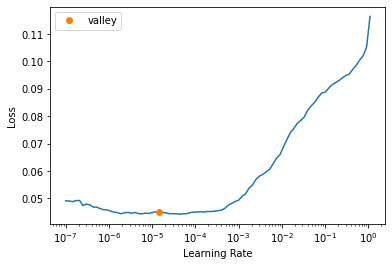

In [32]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [33]:
lr = slice(1e-7,1e-6)

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.043596,0.053020,0.921987,0.918212,0.848791,00:05
1,0.044049,0.052738,0.923225,0.918678,0.849588,00:05
2,0.044717,0.053414,0.924841,0.918253,0.848861,00:05
3,0.044672,0.052868,0.922750,0.918354,0.849035,00:05
4,0.044495,0.053029,0.920803,0.918039,0.848495,00:06
5,0.044568,0.052854,0.920508,0.918244,0.848845,00:05
6,0.044635,0.052722,0.920142,0.918258,0.848870,00:05
7,0.044560,0.053009,0.924601,0.918436,0.849174,00:05
8,0.044700,0.052698,0.918754,0.918195,0.848761,00:05
9,0.044531,0.053275,0.923377,0.917930,0.848310,00:05


Better model found at epoch 0 with valid_loss value: 0.053019896149635315.


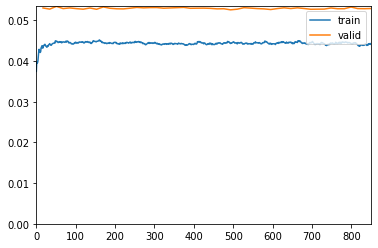

Better model found at epoch 1 with valid_loss value: 0.052737630903720856.
Better model found at epoch 6 with valid_loss value: 0.0527220293879509.
Better model found at epoch 8 with valid_loss value: 0.05269778147339821.
Better model found at epoch 28 with valid_loss value: 0.052561577409505844.


In [34]:
fname="Deeplabv3_Aug_wd3_model_3_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lr ,cbs=callbacksFitBeforeUnfreeze)

In [24]:
learn.freeze()
learn.load("Deeplabv3_Aug_wd3_model_3_resnet50_bs_32")
learn.validate()

(#4) [0.052561577409505844,0.9220765233039856,0.9186151481781768,0.8494803183441806]

Recorder

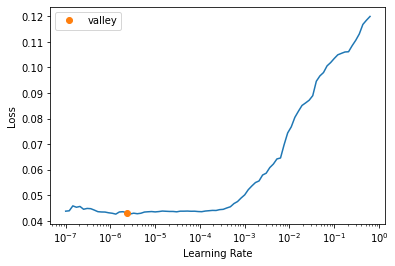

In [25]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.044384,0.053066,0.922831,0.917991,0.848414,00:06
1,0.044197,0.052842,0.924331,0.918363,0.849049,00:06
2,0.044195,0.052901,0.923424,0.918410,0.849129,00:06
3,0.044276,0.052700,0.923118,0.918660,0.849557,00:06
4,0.044166,0.052969,0.923517,0.918496,0.849276,00:06
5,0.044427,0.053080,0.923405,0.918173,0.848724,00:06
6,0.044369,0.052843,0.924230,0.918652,0.849544,00:06
7,0.044199,0.052855,0.922909,0.918491,0.849267,00:06
8,0.044188,0.052828,0.923289,0.918372,0.849065,00:06
9,0.044165,0.052819,0.921673,0.918156,0.848695,00:06


Better model found at epoch 0 with valid_loss value: 0.05306583642959595.


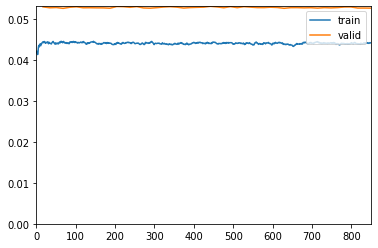

Better model found at epoch 1 with valid_loss value: 0.05284218490123749.
Better model found at epoch 3 with valid_loss value: 0.0527002327144146.


In [26]:
fname="Deeplabv3_Aug_wd3_model_4_resnet50_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-7,3e-6) ,cbs=callbacksFitBeforeUnfreeze)

# Mask prediction 

In [23]:
learn.load("Deeplabv3_Aug_wd3_model_3_resnet50_bs_32")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.052561912685632706,0.9220808744430542,0.918617765364751,0.8494847944997]

This paths contains a few images, just to see if we can get the masks without any ground truth involved.

In [24]:
path2 = path_images/"figure"
path2

Path('../dataset2/Images/figure')

Super important, this datablock is for the images you want to produce masks for. 

In [25]:
dblock = DataBlock(blocks=(ImageBlock),get_items = get_image_files, item_tfms=Resize((160,160)), batch_tfms=Normalize.from_stats(*imagenet_stats))
learn.dls =  dblock.dataloaders(path2, bs=7, num_workers=0)

This is to produce the masks in yellow and purpuple, they are displayed in the notebook. Just change i 

In [38]:
ls = path2.ls()
ls
#17,12 for test 
i =12

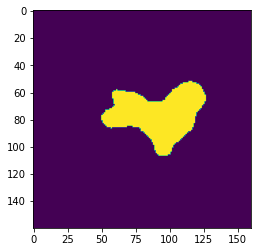

In [39]:
preds =learn.predict(ls[i])
pred_1 = preds[0][1]
plt.imshow(pred_1)

To produce in a automated way the masks here some lines of code. Last time, the code broke becaosue of the directory assigned to store the images. It has to be easy to fix. Otherwise, remove it and the masks will be sotred in working directory. 

In [26]:
import os 
import ntpath
os.mkdir('Predicted_masks_DeepLab_figure')
for file in path2.ls():
    
    filename = os.path.basename(file)
    if "jpg" in os.path.basename(file):
        trial = ntpath.basename(file)
        preds =learn.predict(file)
        pred_1 = preds[0][1]
        pred_arx = pred_1.numpy()
        rescaled = (755.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)
        im = Image.fromarray(rescaled) 
        name_jpg = filename
        name_tif = trial[:-4] +  ".tif"
        im.save(f"Predicted_masks_DeepLab_figure/{name_tif}")
    else:
        print("are you sure the images are in jpg format? :)")

are you sure the images are in jpg format? :)
